<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Optimisation-Implementation" data-toc-modified-id="Optimisation-Implementation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Optimisation Implementation</a></span></li><li><span><a href="#function" data-toc-modified-id="function-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>function</a></span></li><li><span><a href="#Maximisation" data-toc-modified-id="Maximisation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Maximisation</a></span></li><li><span><a href="#Brute-Force-Parameter-Space-Exploration" data-toc-modified-id="Brute-Force-Parameter-Space-Exploration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Brute Force Parameter Space Exploration</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Testing</a></span><ul class="toc-item"><li><span><a href="#Test-values" data-toc-modified-id="Test-values-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Test values</a></span></li></ul></li></ul></div>

In [4]:
# imports
import numpy as np

# Optimisation Implementation
- use scipy.optimisation and just return the inverse which would normally be minimised but by inverting is then maximised when inverted

- optimising with respect to $R_0$

# function

In [5]:
from numpy import exp 
from math import floor as floor
def L(t, k = 0.01):
    """
        Calculates lifetime reproductive output of an organism, 
        as described in Charnov et al. 2001.

        Arguments:
            t {int} -- time
            k {float} -- reproduction senescence
        Returns:
            {float} -- lifetime reproductive output
    """
    return exp(-k*t)


def dRmdt(mR0, t, alpha = 50, M = 1000, a = 2.15, c = 0.17, rho = 0.06, k = 0.01): 
    """
    A function to simulate change in mass and reproductive output for a time point.  
    Function designed with the intention of beign integrated.
    
        Arguments:
        t {float} -- time
        mR0 {array} -- array with mass (g) and reproduction at start of time step 
        alpha {float} -- asymtotic mass (g)
        M {float} -- asymptotic mass (g)
        a {float} -- growth rate (s^-1)
        b {float} -- maintenace cost per cell ## found in function
        c {float} -- reproductive cost (s^-1)
        rho {float} -- scaling factor of reproduction 
        k {float} -- reproductive senesence
        Z {float} -- ## found in function
        
    Returns:
        {scipy.array} -- 
            dmdt --rate of change of mass in grams^1/4 per day (g^1/4 d^-1) at time t
                NOTE:  integration of dmdt will give mass at t
            Rt -- reproductive output at time t in terms of mass 
                NOTE: integration of Rt gives total Reproductive output for the bounds 
                        of the integral
    """
    # predefine outputs 
                
    m = mR0[0] 
    R = mR0[1]
    b = (a/(M**0.25)) -c
    Z = 2/alpha
    Q = L(t-alpha, k)
    
    # conditional tree dependant on `alpha`
    if t < 0:
        return "ERROR: time < 0"
    if t < alpha:
        dmdt = (a * (m**0.75)) - (b * m)
        R = 0
    elif t >= alpha:
        
        dmdt = (a * (m**0.75)) - (b * m) - (c * (m**rho))
        R = Q*c * m**rho
#         R = c * Q * m**rho * exp(-(k + Z) * (t - alpha))
    if m + dmdt < 0: # to set `m` to 0 when it would dip below 0
        dmdt = floor(-m)
    
    return np.array([dmdt, R])
#     return dict["dmdt" : dmdt, "Reproduciton" : R]

def Opt(cRho, params): 
    # input vars reordered to suit minimize? with c and rho to be unpacked?
    """
    A function to maximise the function `dRmdt` to give values of `c` and `rho 
    which result in the greatest `R0` possible.
    
    Arguments:
        cRho {list} -- contains the initial guesses for `c` and `rho`;
            c {float} -- reproductive cost (s^-1)
            rho {float} -- scaling factor of reproduction 
            
        params{list} -- contains the parameters needed to run the integration in the order:
        
            t {float} -- time
            mR0 {float} -- array with mass (g) and reproduction at start of time step 
            alpha {float} -- asymtotic mass (g)
            M {float} -- asymptotic mass (g)
            a {float} -- growth rate (s^-1)
            k {float} -- reproductive senesence
            Z {float} -- ## found in function
        
    Returns:
        {array} --  The sum of the reproduction integral for use with `minimise`
        -------the optimal values for `c` and `rho` which yield 
                    the highest cumulative reproduction-----------
        
    """
    # unpack variables
    c, rho = cRho
    t, mR0, alpha, M, a, k = params
    
    # integrate 
    integral = integrate.odeint(dRmdt, mR0, t, args = (alpha, M, a, c, rho, k))
    # store reproduction
    repro = integral[:,1]
    mass = integral[:,0]
    # sum the integral to have 1 number for optimisation
#     result = sum(repro)
    result = repro[-1]
    
    # to try and avoid shrinking fish 
#     if mass[-1] == 0 or mass[-1] < mass[alpha]:
    if mass[-1] < mass[alpha]:
        result = 0
    
    # return negative result since we are minimising 
    return -result
    

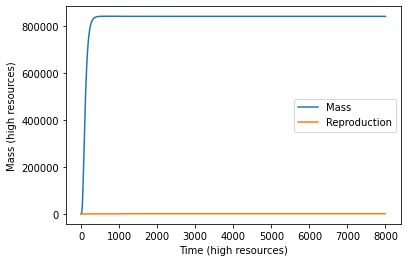

In [6]:
## imports
import matplotlib.pyplot as plt
import scipy as sc
from scipy import integrate
from scipy.optimize import minimize

days = 8000#1500 #  time to simulate over

# define starting parameters -- using cod values from west 2001 as a base/ballpark values

m0 = 0.1 # starting mass at t_0
R0 = 0 # starting reproduction at t_0, 0 because organism not yet mature in my sims
a = 2.15 # cost of new mass 
b =  0 # no need to calculate right now since i do it in function,could be done here to save time
c = 0.1

# reproductive cost 
M =  25000
alpha = 1000 # age of maturation (days)
rho = 0.33 # reproductive scaling parameter
k =  0.01

# organising starting params for use

mR0 = np.array([m0, R0]) # starting values for integration, [starting mass, starting repro]
t = np.arange(0, days, 1) # t values for integration
params = (alpha, M, a, c, rho, k) # tuple for integration arguments


# integration
mR = integrate.odeint(dRmdt, mR0, t, args = params)
mass = mR[:, 0]
repro = mR[:, 1]


# exploring output
# mass[-1000:-675] # final 50 values to check for `nan`




plt.figure()
plt.plot(t, mass, label = "Mass")
plt.plot(t, repro, label =  "Reproduction")
plt.xlabel("Time (high resources)")
plt.ylabel("Mass (high resources)")
plt.legend()
plt.show()


# Maximisation

902.0652847489267
      fun: 0
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.4, 0.2])


/home/donal/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


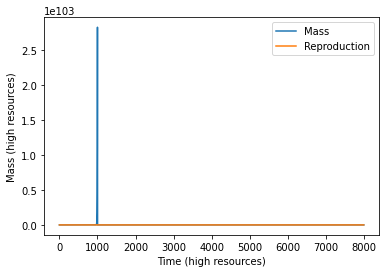

True

In [7]:
import matplotlib.pyplot as plt
########## minimisation #########
c = 0.4
rho = 0.2
cRho = [c, rho]
params = [t, mR0, alpha, M, a, k]

## Sanity check for the opt function
print(repro[-1])
    # minus to re-invert as the function is designed to invert with minus for use with optimise
# print(-Opt(cRho, params)) 
res_obj = minimize(Opt, cRho, args=(params)) 
print(res_obj)
c = res_obj.x[0]
rho = res_obj.x[1]
params = (alpha, M, a, c, rho, k)
mR = integrate.odeint(dRmdt, mR0, t, args = params)
mass = mR[:, 0]
repro = mR[:, 1]
plt.figure()
plt.plot(t, mass, label = "Mass")
plt.plot(t, repro, label =  "Reproduction")
plt.xlabel("Time (high resources)")
plt.ylabel("Mass (high resources)")
plt.legend()
plt.show()

mass[alpha] > mass[-1]

In [8]:
# # to scan parameter space
# ticker = 1
# rhoSpace = np.arange(0, 1.1, 0.5) # .1 intervals
# cSpace = np.arange(0, 1.1, 0.5)
# for i, rho in enumerate(rhoSpace):
#     for j, c in enumerate(cSpace):
#         # assign c and rho
#         cRho = [c, rho]
#         params = [t, mR0, alpha, M, a, k]
#         # run optimisation
#         res_obj = minimize(Opt, cRho, args=(params), method="NELDER-MEAD")
#         c = res_obj.x[0]
#         rho = res_obj.x[1]
#         params = (alpha, M, a, c, rho, k)
#         mR = integrate.odeint(dRmdt, mR0, t, args = params)
#         mass = mR[:, 0]
#         repro = mR[:, 1]
#         # if first iteration assign values
#         if i == 0 and j == 0:
#             OptRepro = repro[-1] 
#             Optrho = rho
#             Optc = c
#         #else compare and assign if better

#         if repro[-1] > OptRepro:
#             OptRepro = repro[-1]
#             Optrho = rho
#             Optc = c 
#             OptRes = res_obj
#             ticker = 1
#         if repro[-1] == OptRepro:
#             ticker = ticker + 1
            
# print(Optc)
# print(Optrho)
# print("Number of optimal results = ", ticker)
    

In [9]:
# c = Optc
# rho = Optrho
# params = (alpha, M, a, c, rho, k)
# mR = integrate.odeint(dRmdt, mR0, t, args = params)
# mass = mR[:, 0]
# repro = mR[:, 1]
# plt.figure()
# plt.plot(t, mass, label = "Mass")
# plt.plot(t, repro, label =  "Reproduction")
# plt.xlabel("Time (high resources)")
# plt.ylabel("Mass (high resources)")
# plt.legend()
# plt.show()
# OptRes

since the above yields `nan` below are listed the algorithms which have non-`nan` returns:
- NELDER-MEAD - seems very robust give good results on visual inspection
- POWELL  -  gives `nan` both params
- CG -  gives `nan` both params
- BFGS -  gives `nan` both params


In [10]:
# minimize
# print(type(mR))
# print(mR[alpha,0])
# print(mR[-1, 0])
# print( mR[-1,0]< mR[alpha, 0])


In [11]:
minimize

<function scipy.optimize._minimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)>

# Brute Force Parameter Space Exploration
- taken from Luke Vassor's methodology

In [12]:
# function to find maximum value from a matrix
### imports
import matplotlib.pyplot as plt
import scipy as sc
from scipy import integrate
from scipy.optimize import minimize

def find_max(array):
    """
        A function to find the maximum of an array and return its indices

        Arguments:
            matrix {np.array} -- the matrix to find the max value of 

        Returns:
            {tuple} --  the indices of the maximum value

    """
    max_ind = np.unravel_index(np.argmax(array, axis=None), array.shape)
    return max_ind

#### set-up ####
days = 2000 #  time to simulate over

# define starting parameters -- using cod values from west 2001 as a base/ballpark values

m0_start = 0.1 # starting mass at t_0
R0_start = 0 # starting reproduction at t_0, 0 because organism not yet mature in my sims
a = 2.15 # cost of new mass 
b =  0 # no need to calculate right now since i do it in function,could be done here to save time


# reproductive cost 
M =  15000
alpha = 100 # age of maturation (days)
k =  0.01


## rho and c
c_max = (a/M**0.25)
resolution = 0.05# the resolution of the parameter space exploration for `rho` and `c`
rho_vec = np.arange(0, 2, resolution)
c_vec = np.arange(0, c_max, resolution)

# array to store final reproduction values
# `c` will be row and `rho` columns, ith val is ith val in c_vec or jth val is jth in rho_vec
R0_array = np.zeros((len(c_vec), len(rho_vec)))







# organising starting params for use

mR0 = np.array([m0_start, R0_start]) # starting values for integration, [starting mass, starting repro]
t = np.arange(0, days, 1) # t values for integration

    
for i, c in enumerate(c_vec):
#     print(c)
    for j, rho in enumerate(rho_vec):
        
        ## simulate with params for the loop
        params = (alpha, M, a, c, rho, k) # tuple for integration arguments
        res = integrate.odeint(dRmdt, mR0, t, args=params)
        mass = res[:,0]
        R0 = res[:,1]
        tot_R0 = R0[-1]
        # check that the outcome is not a shrinking fish
        if mass[-1] < mass[alpha]:
            # if shrinking fish set R0 to -1 to differentiate from other viable results 
            tot_R0 = -1 # <-- change to NA to differentiate?

        ## check for nan values
#         if np.isnan(mass[-1]):
#             tot_R0 = -2

        R0_array[i,j] = tot_R0 
#         ## check that the outcome is not a shrinking fish
#         if mass[alpha] > mass[-1]:
#             # if shrinking fish set R0 to -1 to differentiate from other viable results 
#             R0[-1] = -1 # <-- change to NA to differentiate?
            
#         ## check for nan values
#         if np.isnan(mass[-1]):
#             R0[-1] = -2
        
#         R0_array[i,j] = R0[-1]
        

# replace `nan` with 0
R0_array = np.nan_to_num(R0_array)

R0_array

<ipython-input-5-edf23f3a895d>:58: RuntimeWarning: invalid value encountered in double_scalars
  dmdt = (a * (m**0.75)) - (b * m) - (c * (m**rho))
<ipython-input-5-edf23f3a895d>:59: RuntimeWarning: invalid value encountered in double_scalars
  R = Q*c * m**rho


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 4.99999982e+00,  8.57281507e+00,  1.46986212e+01,
         2.52016025e+01,  4.32091406e+01,  7.40822482e+01,
         1.27009015e+02,  2.17730617e+02,  3.73195660e+02,
         6.39477944e+02,  1.09

In [13]:
np.meshgrid(c_vec, rho_vec)

[array([[0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  , 0.05, 0.1 , 0.15],
        [0.  ,

In [14]:
max_ind = find_max(R0_array)
print(max_ind)
max_R0 = R0_array[max_ind]
c_opt = c_vec[max_ind[0]]
rho_opt = rho_vec[max_ind[1]]
        
        ## add a way to make sure that there is not more than one max
# multi = np.where(R0_array == R0_array[max_ind])
# multi
        ## make fancy heatmap

(3, 17)


In [15]:
# np.unique(R0_array)

In [16]:
print(max_R0)
print(c_opt)
print(rho_opt)

2360347.306257649
0.15000000000000002
0.8500000000000001


In [17]:
print("rho is :", rho_opt)
print("c is :", c_opt)
"old rho is : 1.15"
"old c is : 0.01"

rho is : 0.8500000000000001
c is : 0.15000000000000002


'old c is : 0.01'

In [18]:

R0_array[max_ind]
# R0_array


2360347.306257649

# Testing

## Test values

In [ ]:
## imports
import scipy as sc
from scipy import integrate

rho = rho_opt
c = c_opt
# organising starting params for use


params = (alpha, M, a, c, rho, k) # tuple for integration arguments


# integration
mR = integrate.odeint(dRmdt, mR0, t, args = params)
mass = mR[:, 0]
repro = mR[:, 1]


######plotting
import matplotlib.pyplot as plt

plt.figure()
plt.grid(True)
plt.plot(t[:1000], mass[:1000], label = "Somatic Growth")
plt.plot(t[:1000], repro[:1000], label = "Cumulative Reproduction")
plt.xlabel("Time")
plt.ylabel("Mass")
plt.legend()
plt.show()

print("rho is: ", rho)
print("c is: ", c)

In [ ]:
# check of `b` value with c
print((a/M**0.25) -c)
# check without
print(a/M**0.25)

In [ ]:
# check for shrinking
print(mass[alpha])
print(mass[-1])
mass[alpha] > mass[-1] # if true then the fish is shrinking

store =[]
for i, m in enumerate(mass):
    if i == 0:
        None
    elif m < mass[i-1]:
        print("shrank at: ", i-1)
        store.append(i-1)
    else:
        None

In [ ]:
mass[300:310]
mass[store[:100]]
plt.figure()
plt.plot(store)

In [ ]:
def tes(m,t):
    a = 2.15
    M = 15000
    b = (a/(M**0.25)) 
    alpha = 500
    c = 0.05
    rho = 1.1
    Q = L(t)
    if t < alpha:
        dmdt = (a * (m**0.75)) - (b * m)
        R0 = 0
    else:
        dmdt = (a * (m**0.75)) - (b * m) - (c * (m**rho))
        R = Q*c * m**rho
    if dmdt * m < 0:
        dmdt = -m #<<<<< problem?
        
    return dmdt
t = np.arange(0, 8000, 1)
mass = integrate.odeint(tes, 0.1, t)[500:600]
plt.figure()
plt.plot(t[500:600], mass)

mass

# Currently things are growing too fast so when they reach "maturity" they are already fully grown
# this leaves no way for the new introduction of R0 cost to cause eq and either crashes or shrinks a bit

In [ ]:
# array testing 
test = np.array(np.random.uniform(low= -2, high = 100,size=10000)).reshape(100,100)
# np.unravel_index(np.argmax(test))
test = R0_array
max_ind = np.unravel_index(np.argmax(test, axis=None), test.shape)
print(max_ind)
print(test)
print(test[max_ind])
R0_array[find_max(R0_array)]



In [1]:
from numpy import arange
arange(0,1,1)

array([0])